In [1]:
import numpy as np

In [2]:
hist = np.array([
    [4, 0],
    [3, 2]
])

In [3]:
miou = (np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist) + 1) ).mean()
print(miou)

0.41666666666666663


In [4]:
print(np.diag(hist).sum())
print(np.sum(hist))
pa = np.diag(hist).sum() / np.sum(hist)
print(pa)

6
9
0.6666666666666666


In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import numpy as np

from modeling.unet import Unet
from dataset.custom_dataset import MyDataset

def calPA(pred, label):
    nc = pred.shape[1]
    _, index = pred.max(dim=1)
    index, label = index.cpu().numpy(), label.cpu().numpy()
    pa = 0.0
    for i, l in zip(index, label):
        hist = np.zeros((nc, nc), dtype=int)
        for ri, rl in zip(i, l):
            hist += np.bincount(nc*rl.astype(int)+ri, minlength=nc**2).reshape(nc, nc)
        pa += np.diag(hist).sum() / np.sum(hist)
    return pa


def loadData():
    datapath = './iccv09Data'
    data_transforms = transforms.Compose([
        # transforms.RandomCrop(32, padding=4), #随机裁剪
        # transforms.RandomHorizontalFlip(), # 翻转图片
        transforms.Resize((240, 320)),
        transforms.ToTensor()
    ])
    train_dataset = MyDataset(datapath, True, data_transforms)
    train_loader = DataLoader(train_dataset, 4)
    test_dataset = MyDataset(datapath, False, data_transforms)
    test_loader = DataLoader(test_dataset, 1)
    return (train_loader, test_loader)


def test(testLoader, model, lossFunction, device):
    model.eval()
    tloss, totalBatch = 0, 0
    tpa = 0.0
    totalCount = len(testLoader)
    with torch.no_grad():
        for batch, (data, label) in enumerate(testLoader):
            totalBatch += 1
            # convert
            data, label = data.to(device), label.to(device)
            label = label.to(torch.int64).squeeze(dim=1)
            # calculate
            pred = model(data)
            loss = lossFunction(pred, label)
            # add
            tloss += loss.item()
            tpa += calPA(pred, label)
    return (tloss/totalBatch, tpa/totalCount)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

trainLoader, testLoader = loadData()

model = Unet(3, 9).to(device)
model.load_state_dict(torch.load('./saves/model.pth'))
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

print("Begin Training")
for epoch in range(64):
    print(f"Epoch:{epoch+1:>3}, learning rate = {0.1}")

    testLoss, testAcc = test(testLoader, model, lossFunction, device)
    with open('./result.txt', 'a') as f:
        nowTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        f.write(f'[{nowTime}] Epoch{epoch+1:>3d}\n')
        f.write(f'    Test:  Loss {testLoss :>7.6f}, mIOU {testAcc :>6.4f}\n')
    # torch.save(model.state_dict(), './saves/model.pth')
print("Done")


Using cuda device
Begin Training
Epoch:  1, learning rate = 0.1
Epoch:  2, learning rate = 0.1
Epoch:  3, learning rate = 0.1
Epoch:  4, learning rate = 0.1
Epoch:  5, learning rate = 0.1
Epoch:  6, learning rate = 0.1
Epoch:  7, learning rate = 0.1


KeyboardInterrupt: 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

from dataset.custom_dataset import MyDataset
from myTransforms import FixScaleCrop, RandomScaleCrop, PadCrop

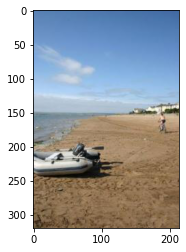

torch.Size([3, 320, 214])


In [2]:
image = Image.open('./iccv09Data/images/0003423.jpg')
plt.imshow(image)
plt.show()
timage = transforms.ToTensor()(image)
print(timage.shape)

(320, 240)
torch.Size([3, 240, 320])


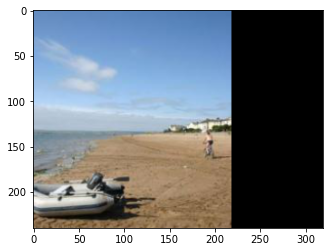

In [9]:
# imagec = FixScaleCrop((240, 320), True)(image)
imagec = RandomScaleCrop((240, 320), (240, 320), 8, True)(image)
# imagec = PadCrop((240, 320), 8, True)(image)
print(imagec.size)
plt.imshow(imagec)
timagec = transforms.ToTensor()(imagec)
print(timagec.shape)

In [44]:
from torchvision import transforms

f = transforms.RandomHorizontalFlip()
print(type(f))
print(isinstance(f, transforms.RandomHorizontalFlip))
print(f.p)

ff = transforms.Compose([
    # transforms.RandomCrop(32, padding=4), #随机裁剪
    transforms.RandomHorizontalFlip(), # 翻转图片
    # FixScaleCrop((240, 320), True),
    # PadCrop((240, 320), 8, True)
    # transforms.Resize((240, 320), transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor()
])
fs = ff.transforms
print(type(fs))
print(isinstance(fs, list))
print(fs)

<class 'torchvision.transforms.transforms.RandomHorizontalFlip'>
True
0.5
<class 'list'>
True
[RandomHorizontalFlip(p=0.5), ToTensor()]


In [3]:
from dataset.custom_dataset import MyDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch


datapath = './iccv09Data'
image_transforms = transforms.Compose([
    # transforms.RandomCrop(32, padding=4), #随机裁剪
    # transforms.RandomHorizontalFlip(), # 翻转图片
    # FixScaleCrop((240, 320), True),
    # PadCrop((240, 320), 8, True)
    transforms.Resize((240, 320), transforms.InterpolationMode.BILINEAR),
    transforms.GaussianBlur(3, 1),
    transforms.ToTensor(),
    # transforms.Normalize((0.4817, 0.4906, 0.4749), (0.2500, 0.2495, 0.2752))
])
mask_transforms = transforms.Compose([
    # transforms.RandomCrop(32, padding=4), #随机裁剪
    # transforms.RandomHorizontalFlip(), # 翻转图片
    # FixScaleCrop((240, 320), False),
    # PadCrop((240, 320), 8, False)
    transforms.Resize((240, 320), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])
train_dataset = MyDataset(datapath, True, image_transforms, mask_transforms)
train_loader = DataLoader(train_dataset, 1)

lc, rc = 0, 0
for (image, mask) in train_loader:
    # print(image, image.dtype)
    image = image.squeeze(0)
    img = transforms.ToPILImage()(image)
    img.show()
    # print(mask)
    break
    # if (mask.equal(lmask)):
    #     print('l')
    #     lc += 1
    # if (mask.equal(rmask)):
    #     print('r')
    #     rc += 1
# print(lc, rc, lc+rc)

In [4]:
lmask = torch.zeros_like(mask)
lmask.copy_(mask)

tensor([[[[5, 5, 5,  ..., 0, 0, 8],
          [5, 5, 5,  ..., 0, 0, 8],
          [5, 5, 5,  ..., 0, 0, 8],
          ...,
          [5, 5, 5,  ..., 5, 5, 8],
          [5, 5, 5,  ..., 5, 5, 8],
          [5, 5, 5,  ..., 5, 5, 8]]]], dtype=torch.int32)

In [2]:
rmask = torch.zeros_like(mask)
rmask.copy_(mask)

tensor([[[[8, 0, 0,  ..., 5, 5, 5],
          [8, 0, 0,  ..., 5, 5, 5],
          [8, 0, 0,  ..., 5, 5, 5],
          ...,
          [8, 5, 5,  ..., 5, 5, 5],
          [8, 5, 5,  ..., 5, 5, 5],
          [8, 5, 5,  ..., 5, 5, 5]]]], dtype=torch.int32)

In [41]:
print(mask.equal(lmask))
print(mask.equal(rmask))
print(lmask.equal(rmask))

True
False
False
